<a href="https://colab.research.google.com/github/kumar-neelabh/minor-project/blob/master/Deep_SVDD_First_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from keras import regularizers
from keras import layers
from keras.datasets import mnist
import keras.backend as K
import copy
%matplotlib inline

# Dataset : MNIST (Specify Digit Here)
Skipping Global Contrast Normalization (GCN) for first implementation

In [0]:
DIGIT = 7

In [0]:
def scale(X):
  """
  Scaling all data to [0,1] w.r.t. the min and max in the train data is very
  important for networks without bias units. (data close to zero would
  otherwise not be recovered)
  """
  X = X.astype(float)

  X_min = np.min(X)
  X_max = np.max(X)

  X -= X_min

  X /= (X_max - X_min)

  return X

def expand_dims(X):
  return np.expand_dims(X, 3)
  

# min-max scaling
def preprocess(X):
  X = scale(X)
  X = expand_dims(X)
  return X


In [0]:
# Training only on DIGIT's samples. Testing on ALL samples.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

filter_ = np.isin(y_train, [DIGIT])
filtered_x_train, filtered_y_train = x_train[filter_], y_train[filter_]

processed_x_train, processed_x_test = preprocess(filtered_x_train), preprocess(x_test)

# Model : LeNet
Approximating Global Weight Decay (not possible in Keras; only a Numpy weights matrix is extractable) by using L2-Regularizers in every layer

Leakiness = 0.01 as per https://github.com/lukasruff/Deep-SVDD/blob/master/src/neuralnet.py

In [0]:
height = x_train.shape[1]
width = x_train.shape[2]
channels = x_train.shape[3] if (len(x_train.shape) == 4) else 1

In [0]:
model = Sequential()

model.add(layers.Conv2D(name='Conv_1', use_bias=False, kernel_regularizer=regularizers.l2(0.01), filters=8, kernel_size=(5, 5), padding='same', input_shape=(height, width, channels)))
model.add(layers.LeakyReLU(name='LeakyReLU_1', alpha=0.01))
model.add(layers.MaxPooling2D(name='MaxPool_1', strides=(1, 1), padding='same'))

model.add(layers.Conv2D(name='Conv_2', use_bias=False, kernel_regularizer=regularizers.l2(0.01), filters=4, kernel_size=(5, 5), padding='same'))
model.add(layers.LeakyReLU(name='LeakyReLU_2', alpha=0.01))
model.add(layers.MaxPooling2D(name='MaxPool_2', strides=(1, 1), padding='same'))

model.add(layers.Flatten(name='Flatten'))

model.add(layers.Dense(name='Dense', use_bias=False, kernel_regularizer=regularizers.l2(0.01), units=32, activation = 'softmax'))

# Training

### Finding center of circle (mean of sample data in output space)

In [0]:
shuff = copy.deepcopy(processed_x_train)
np.random.shuffle(shuff)
sample = shuff[0 : int(len(shuff) / 4)]

In [0]:
outputs = model.predict(sample)
center = np.mean(outputs, axis = 0)
center.shape

(32,)

In [0]:
center = np.reshape(center, (1, 32))

### Custom objective function

In [0]:
def custom_loss(c, lamda, weights):
  
    def loss(y_true, y_pred):
      distance_term = K.mean(K.square(y_pred - c))
      return distance_term
    
    return loss

In [0]:
model.compile(optimizer='adam',
              loss=custom_loss(center, 1e-5, model.get_weights()))

### Fitting

In [0]:
model.fit(processed_x_train, filtered_y_train)

Epoch 1/1
6265/6265 [==============================] - 12s 2ms/step - loss: 0.0567


# Testing

In [0]:
preds = model.predict(processed_x_test)

In [0]:
scores = np.sum((preds - center)**2, axis = 1)

### Accuracy

In [0]:
thresh = np.percentile(scores, 100 * (len(filtered_y_train) / len(y_train)))

In [0]:
y_pred = []
for score in scores:
  if score < thresh:
    y_pred.append(1)
  else:
    y_pred.append(0)
    
y_pred = np.array(y_pred)

In [0]:
y_true = []
for label in y_test:
  if label == DIGIT:
    y_true.append(1)
  else:
    y_true.append(0)
    
y_true = np.array(y_true)

In [0]:
print("accuracy : ", 1 - (y_true - y_pred).sum() / len(y_true))

accuracy :  0.9977


# Visualization #1

Let's look at the most normal and most anomalous examples from the same class

In [0]:
len(scores)

10000

In [0]:
filter_ = np.isin(y_test, [DIGIT])
filtered_x_test, filtered_y_test, filtered_scores = x_test[filter_], y_test[filter_], scores[filter_]

In [0]:
spectrum = np.argsort(filtered_scores)

## Typical Examples

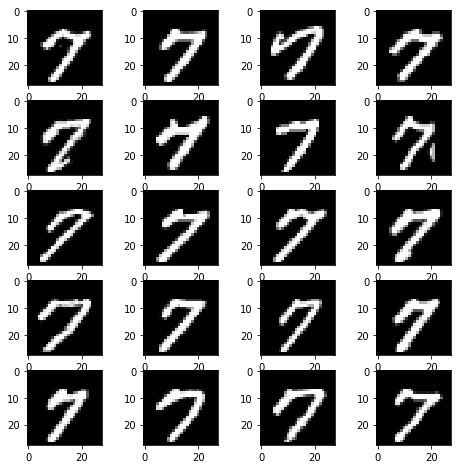

In [0]:
w, h = 10, 10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

rank = 0
for i in range(1, columns*rows +1):
    img = filtered_x_test[spectrum[rank]]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    rank += 1
plt.show()

## Anomalous Examples

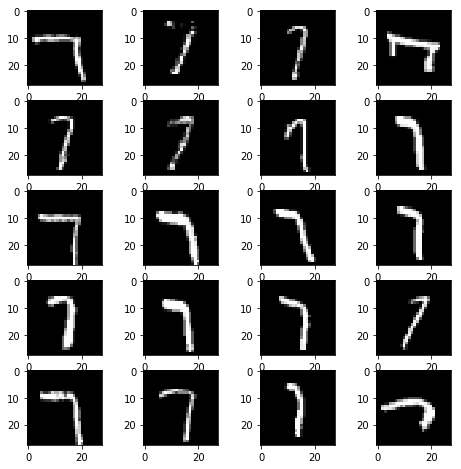

In [0]:
w, h = 10, 10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

rank = 1
for i in range(1, columns*rows +1):
    img = filtered_x_test[spectrum[-rank]]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    rank += 1
plt.show()

# Visualization #2
Let's look at wrongly classified examples